<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/monet_painter_generative_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monet Painter Generative Deep Learning



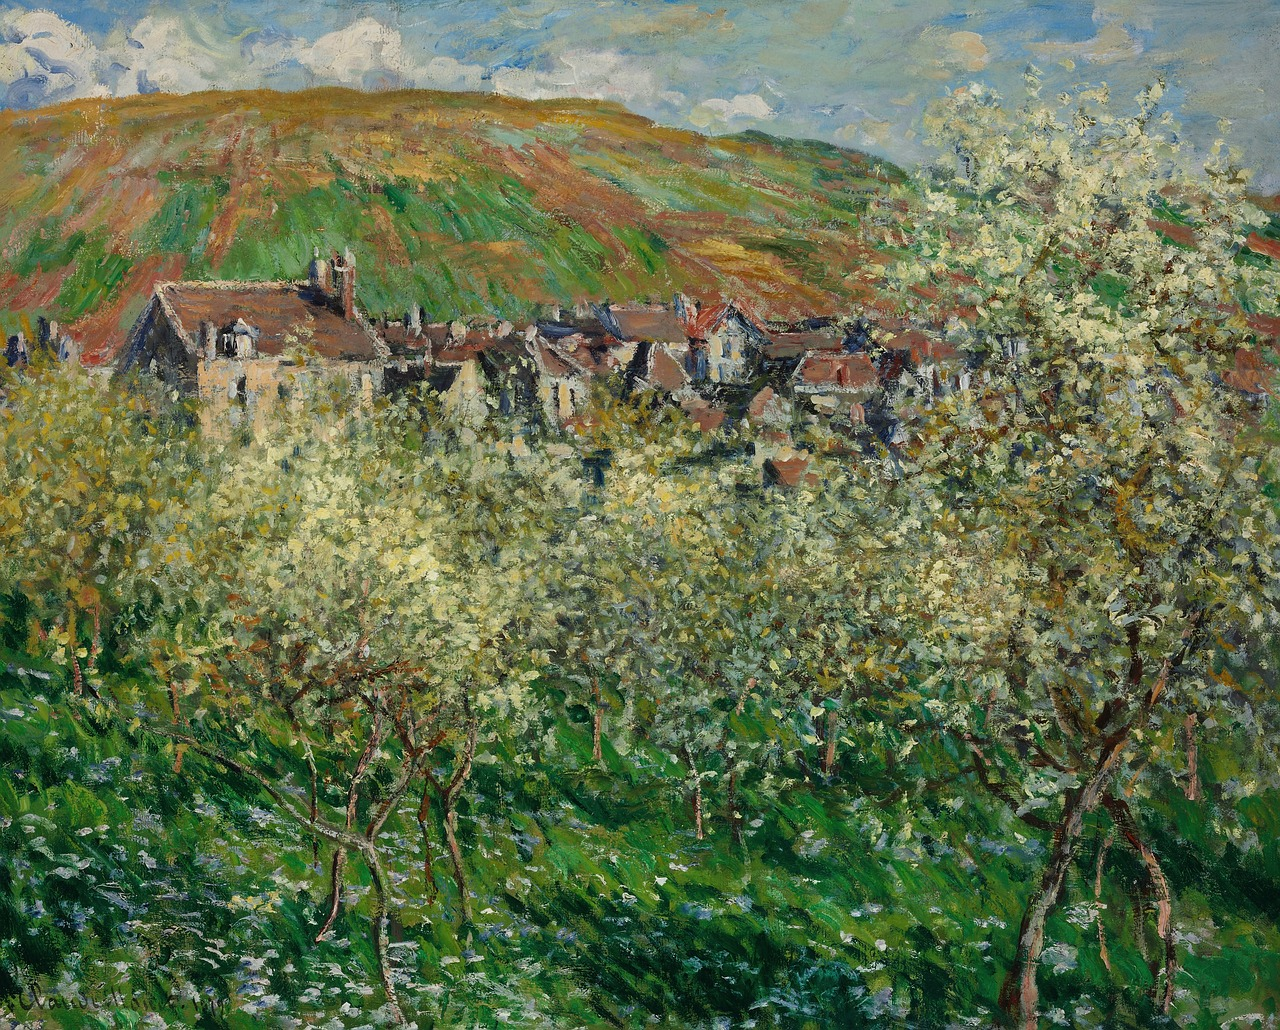

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling.

There are two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

## Downloading and Exploring the Data

In [ ]:
import os
import cv2
import torch
import torchvision
import tarfile
import itertools
import shutil
from PIL import Image
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
dataset_url = ('https://www.kaggle.com/competitions/gan-getting-started')

In [ ]:
import opendatasets as od

In [ ]:
od.download(dataset_url)

100%|██████████| 367M/367M [00:04<00:00, 91.8MB/s]



Extracting archive ./gan-getting-started/gan-getting-started.zip to ./gan-getting-started


In [ ]:
data_dir = 'gan-getting-started'

In [ ]:
os.listdir(data_dir)

['photo_jpg', 'monet_jpg', 'monet_tfrec', 'photo_tfrec']

In [ ]:
for cls in os.listdir(data_dir+'/'): print(cls, ':', len(os.listdir(data_dir+'/' + cls)))

photo_jpg : 7038
monet_jpg : 300
monet_tfrec : 5
photo_tfrec : 20


Let's load this dataset using the ImageFolder class from torchvision.

In [ ]:
image_size = 64
BATCH_SIZE = 5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')

        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]

        self.transforms = transforms

    def __len__(self):
        return len(self.files_A)

    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]

        img_A = Image.open(file_A)
        img_B = Image.open(file_B)

        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)

        return img_A, img_B

In [ ]:
transforms_dataset = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)])

In [ ]:
train_dl = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 3
)

test_dl = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 3
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

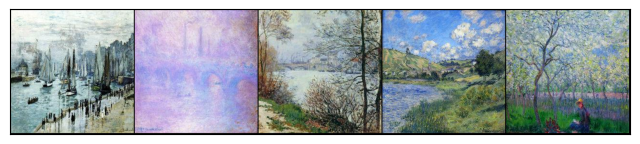

In [ ]:
show_batch(train_dl)

##Discriminator Network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16

            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )

        self.scale_factor = 16

    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        return layers

    def forward(self, x):
        return self.model(x)

## Generator Network
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        channels = out_channels

        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)

        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)

        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)

        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x


In [ ]:
fixed_latent = torch.randn(64, 1, 1, device=device)


## Initalize Generator and Discriminator

In [ ]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

## Define Loss

In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle  = nn.L1Loss()
criterion_identity  = nn.L1Loss()

## Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

## Transfer models to device

In [ ]:
cuda_device = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_device else torch.Tensor
print(f'CUDA Available: {cuda_device}')

CUDA Available: True


In [ ]:
models = [G_AB, D_B, G_BA, D_A]
for model in models:
  if device:
    G_AB = to_device(G_AB, device)
    D_B = to_device(D_B, device)
    G_BA = to_device(G_BA, device)
    D_A = to_device(D_A, device)

    criterion_GAN  = to_device(criterion_GAN , device)
    criterion_cycle  = to_device(criterion_cycle , device)
    criterion_identity = to_device(criterion_identity, device)

print(f'cuda: {device}')

cuda: cuda


## Configure Optimizers

In [ ]:
lr = 0.0002
b1 = 0.5
b2 = 0.996

In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()),
 lr=lr, betas=(b1, b2))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))

optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

## Learning Rate Decay

In [ ]:
n_epoches = 160
decay_epoch = 20

In [ ]:
lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

## Let's create a sample images real and generated

In [ ]:
def sample_images(real_A, real_B):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'

    G_AB.eval()
    G_BA.eval()

    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()

    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(real_A.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain A")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_B.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain B")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_B.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain B")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_A.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain A")
    axs[1, 1].axis('off')



    plt.tight_layout()
    plt.show()

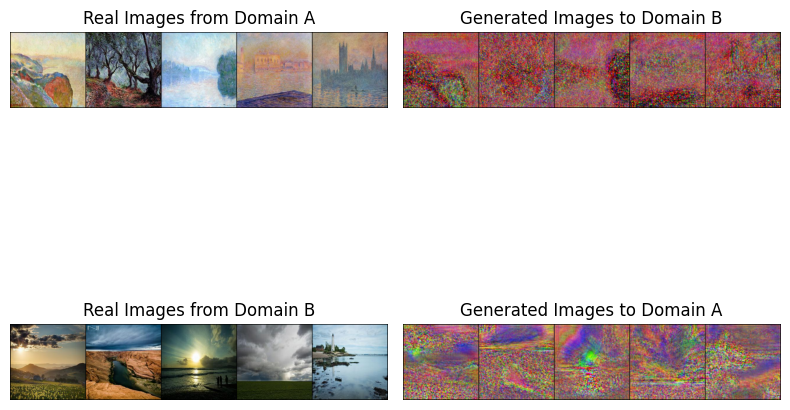

In [ ]:
real_A, real_B = next(iter(test_dl))
sample_images(real_A, real_B)

## Training the model
We are now ready to train the model.

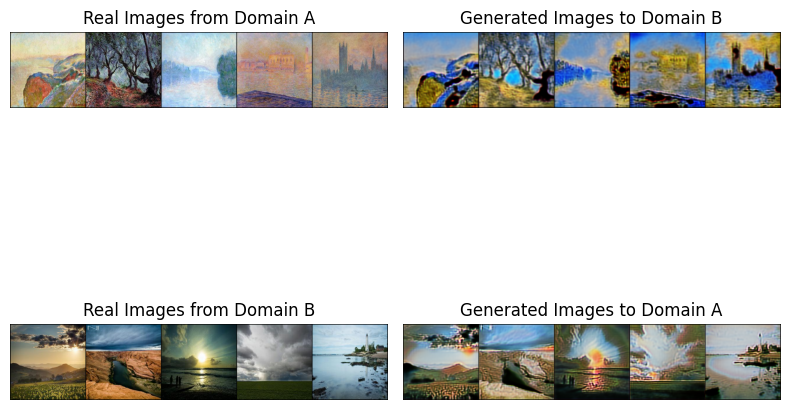

[Epoch 20/160]
[G loss: 4.933220386505127 | identity: 0.2652636468410492 GAN: 0.5265101194381714 cycle: 0.30803918838500977]
[D loss: 0.1667531132698059 | D_A: 0.19502298533916473 D_B: 0.13848324120044708]


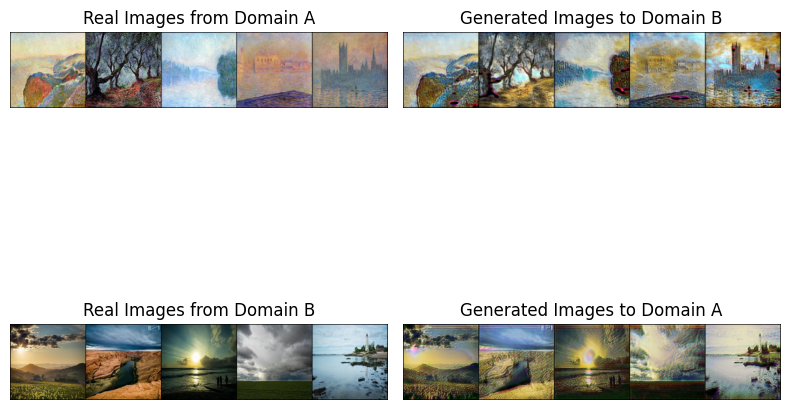

[Epoch 40/160]
[G loss: 3.5910239219665527 | identity: 0.20791935920715332 GAN: 0.46984320878982544 cycle: 0.20815840363502502]
[D loss: 0.1298999935388565 | D_A: 0.12130177021026611 D_B: 0.1384982168674469]


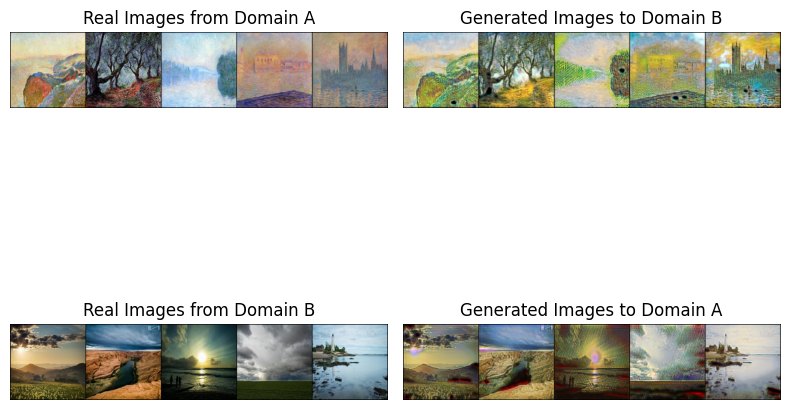

[Epoch 60/160]
[G loss: 3.493351936340332 | identity: 0.20328325033187866 GAN: 0.7725115418434143 cycle: 0.17044241726398468]
[D loss: 0.0723913311958313 | D_A: 0.08354935795068741 D_B: 0.06123330816626549]


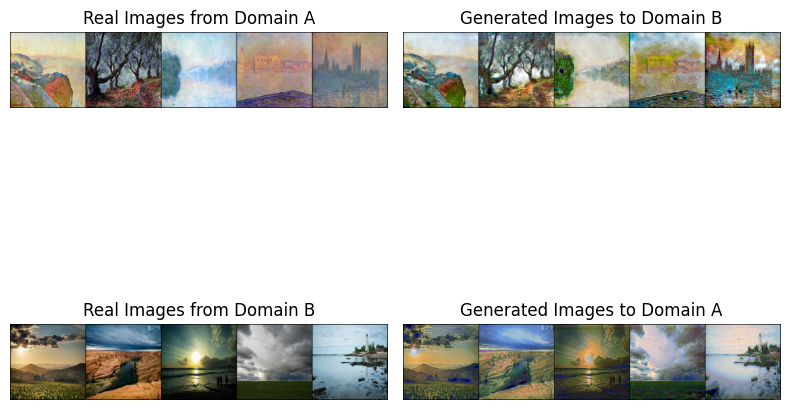

[Epoch 80/160]
[G loss: 3.244694232940674 | identity: 0.20374947786331177 GAN: 0.6862407922744751 cycle: 0.1539706289768219]
[D loss: 0.08465011417865753 | D_A: 0.08065702766180038 D_B: 0.08864319324493408]


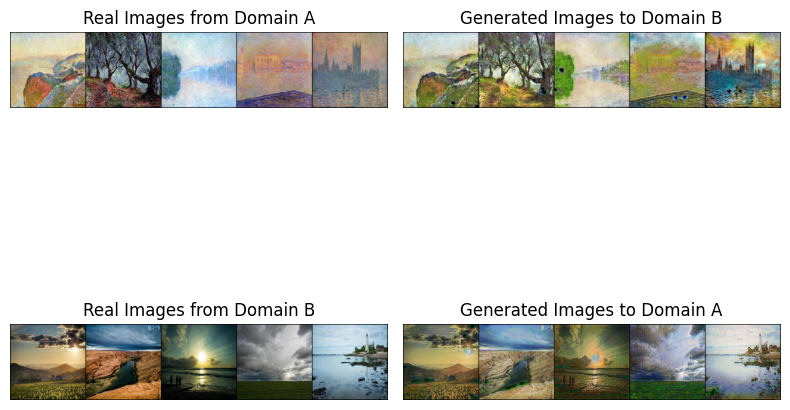

[Epoch 100/160]
[G loss: 3.0097546577453613 | identity: 0.18233998119831085 GAN: 0.6651238203048706 cycle: 0.143293097615242]
[D loss: 0.10565315186977386 | D_A: 0.11007493734359741 D_B: 0.10123136639595032]


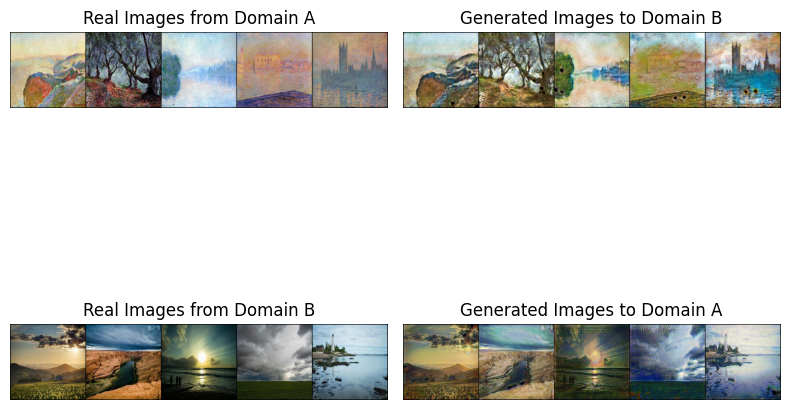

[Epoch 120/160]
[G loss: 2.56619930267334 | identity: 0.17728284001350403 GAN: 0.5909746885299683 cycle: 0.10888104140758514]
[D loss: 0.10377063602209091 | D_A: 0.09609821438789368 D_B: 0.11144305765628815]


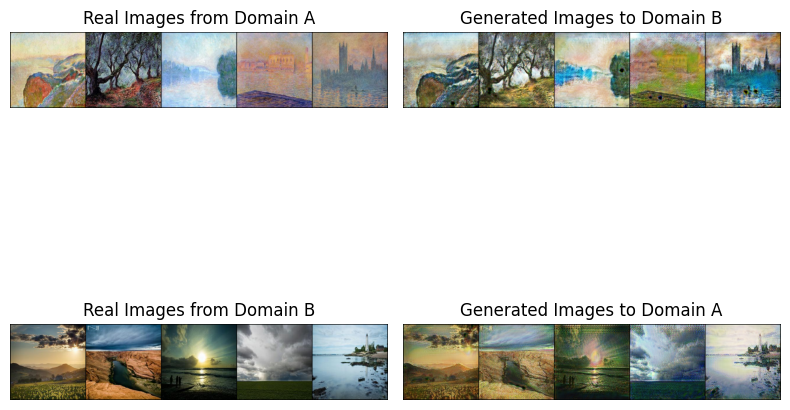

[Epoch 140/160]
[G loss: 2.7154955863952637 | identity: 0.19556009769439697 GAN: 0.5002824664115906 cycle: 0.1237412542104721]
[D loss: 0.09148883074522018 | D_A: 0.10112957656383514 D_B: 0.08184808492660522]


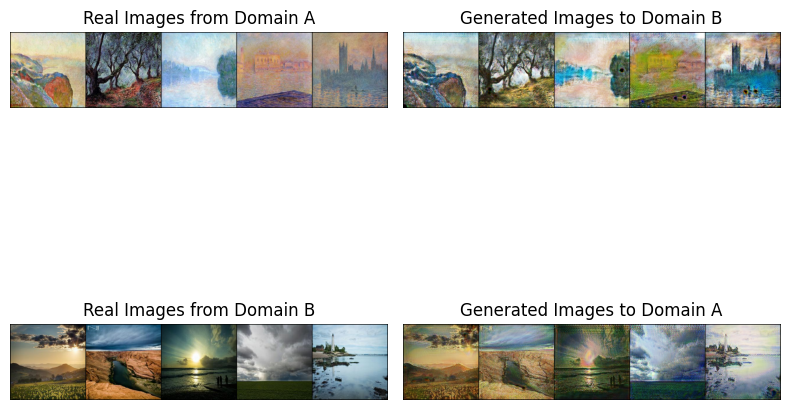

[Epoch 160/160]
[G loss: 2.7994260787963867 | identity: 0.19810722768306732 GAN: 0.522428035736084 cycle: 0.12864618003368378]
[D loss: 0.10953865945339203 | D_A: 0.11613905429840088 D_B: 0.10293827205896378]


In [ ]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(train_dl):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)

        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)

        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle

        loss_G.backward()
        optimizer_G.step()

        """Train Discriminator A"""
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        """Train Discriminator B"""
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # test
    if (epoch+1) % 20 == 0:
        test_real_A, test_real_B = next(iter(test_dl))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')

## Inference and Submission

In [ ]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]

In [ ]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
generate_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = T.ToPILImage()

G_BA.eval()
for i in range(0, len(files), BATCH_SIZE):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+BATCH_SIZE)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_BA(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'